# Exploratory and Predictive Data Analysis of Instagram Tiime and Labels DataSet

## Author: Bill Dusch

In this notebork, we investigate the labels created by Google Vision on instagram posts. Each label has a score from 0 to 1 indicating how likely that the picture corresponds to that label. We will also investigate the time each instagram post is made by the hour and the day. The Instagram Machine Learning competition is a regression problem where we try to predict the number of likes an Instagram post makes in 24 hours. We will predict  the number of likes from the time, day, and label score for posts in the training set, and select the model based on the maximum number of points (absolute error over a given threshold for a user) for each user.

### Imports

First, let's import what we need:

In [1]:
import numpy as np
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

import scipy.stats as stats

# Machine Learning
# supervised learning
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
# model selection
from sklearn.model_selection import GridSearchCV
# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
# unsupervised learning
from sklearn.decomposition import PCA

# Import from Instagram package
from data import usernames, thresholds
from score import get_points, instagram_scorer
# These are the instagram accounts we are investigating
print usernames
print thresholds

['kissinfashion', 'instagood', 'beautifuldestinations', 'etdieucrea', 'josecabaco']
{'beautifuldestinations': 0.105, 'kissinfashion': 0.095, 'josecabaco': 0.185, 'etdieucrea': 0.145, 'instagood': 0.145}


Next, we will import the data. The data has been prepared ultimately from the JSON file as seen in other scripts (in particular, we run data.py, then data_create.py, then data_munging.py) and placed in a series of CSV files (USER.csv for the whole dataset, and split into training and test datasets as train_USER.csv and test_USER.csv)

Since the dataframes are stored in a per user basis, the ultimate objects we will manipulate is a dictionary of dataframes, keyed by the username stored in data.usernames.

In [2]:
labels = {user: pd.read_csv(('../data/labels/' + user + '.csv'), sep='\t', encoding='utf-8')
              for user in usernames}
train = {user: pd.read_csv(('../data/labels/' + 'train_' + user + '.csv'), sep='\t', encoding='utf-8')
              for user in usernames}
test = {user: pd.read_csv(('../data/labels/' + 'test_' + user + '.csv'), sep='\t', encoding='utf-8')
              for user in usernames}

## Exploratory Data Analysis
We will first investigate the nature of the prepared dataframes. We will list the features in the dataset (which should contain the likes, username, display URL, hour and day of the post, and the most common labels in the dataset (> 10 occurances for the whole dataset to reduce labels from 1416 to <200 to make the dataset less sparse)

In [3]:
# List all the features of the dataset
for user in usernames:
    print user
    print labels[user].dtypes
    print

kissinfashion
likes                     int64
username                 object
display_src              object
hour                      int64
day                       int64
toy                     float64
product                 float64
interaction             float64
textile                 float64
fur                     float64
vacation                float64
sea                     float64
hair                    float64
clothing                float64
black_hair              float64
hairstyle               float64
long_hair               float64
brown_hair              float64
blond                   float64
undergarment            float64
supermodel              float64
leg                     float64
finger                  float64
photo_shoot             float64
thigh                   float64
abdomen                 float64
hand                    float64
human_body              float64
model                   float64
neck                    float64
                         .

In [5]:
# Get Summary statistics
for user in usernames:
    print user
    print labels[user]['likes'].describe(), labels[user]['hour'].describe(), labels[user]['day'].describe()
    print

kissinfashion
count     1007.000000
mean     23844.772592
std       5419.584051
min       1351.000000
25%      20007.000000
50%      23500.000000
75%      27604.000000
max      46712.000000
Name: likes, dtype: float64 count    1007.000000
mean       14.874876
std         5.537531
min         0.000000
25%        12.000000
50%        16.000000
75%        19.000000
max        23.000000
Name: hour, dtype: float64 count    1007.000000
mean        3.019861
std         2.009323
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max         6.000000
Name: day, dtype: float64

instagood
count     1006.000000
mean      9656.341948
std       2714.324404
min        996.000000
25%       7901.250000
50%       9384.000000
75%      11162.250000
max      21813.000000
Name: likes, dtype: float64 count    1006.000000
mean       12.669980
std         7.339421
min         0.000000
25%         4.000000
50%        14.000000
75%        19.000000
max        23.000000
Name: hour

Get distribution of likes

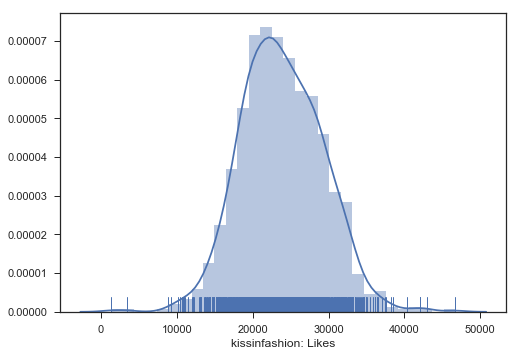

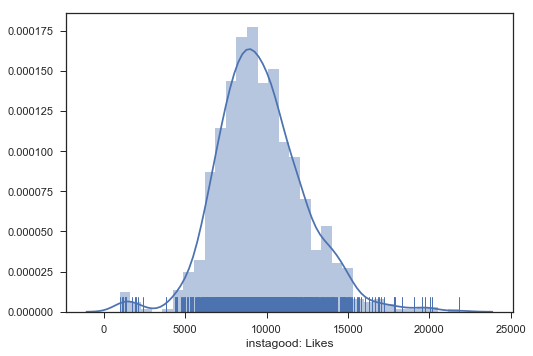

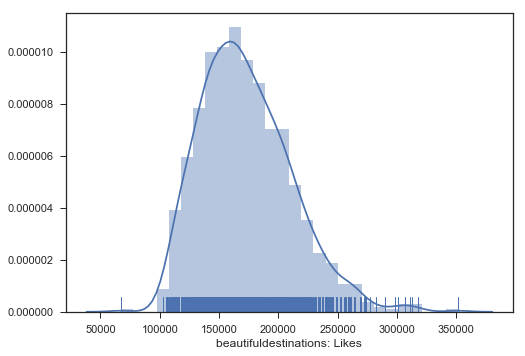

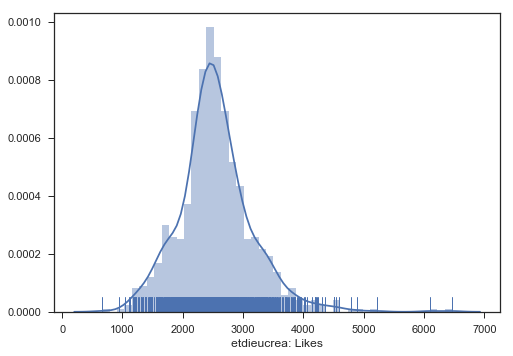

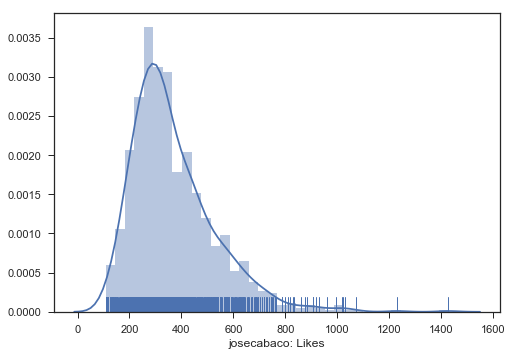

In [6]:
for user in usernames:
    name = user + ": Likes"
    sns.distplot(labels[user]['likes'], rug=True, axlabel=name)
    sns.plt.show()

In [7]:
# Check normality of data
alpha = 0.05
for user in usernames:
    chi2, p = stats.normaltest(labels[user]['likes'])
    if p > alpha:
        print '{}: {}'.format(user, p)
    else:
        print '{}: {}*'.format(user, p)

kissinfashion: 0.00233644758304*
instagood: 2.68902100841e-14*
beautifuldestinations: 1.37194460263e-19*
etdieucrea: 5.24321055853e-41*
josecabaco: 2.23935987267e-66*


All of the likes are normally distributed with p < 0.05; highest p-value is kissinfashion with p = 0.002.

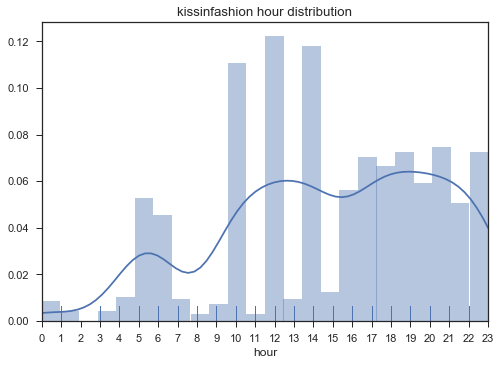

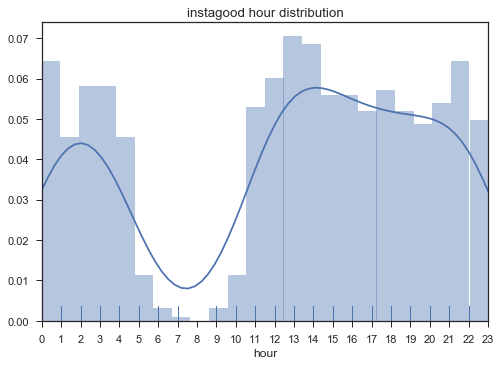

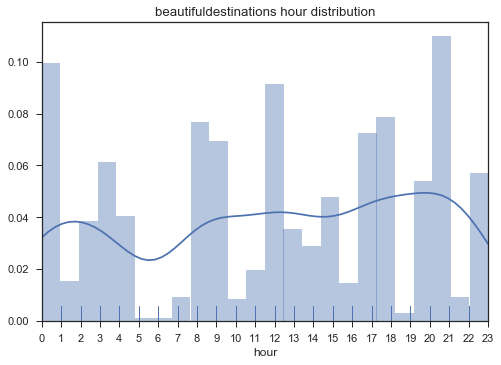

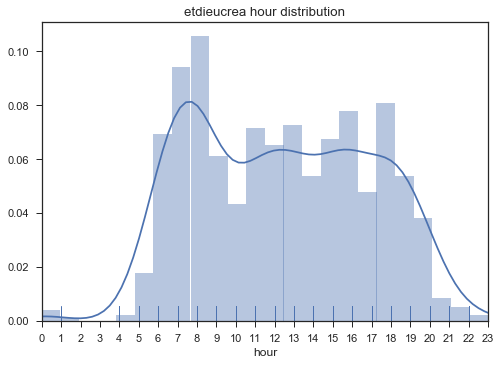

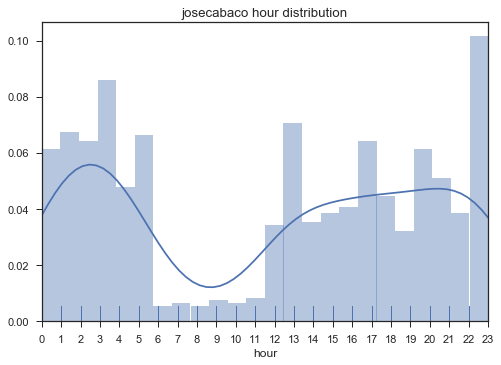

In [8]:
# Get distribution of hour
for user in usernames:
    sns.distplot(labels[user]['hour'], rug=True, bins=24)
    plt.xticks([x for x in range(24)])
    plt.xlim(0, 23)
    plt.title("{} hour distribution".format(user))
    sns.plt.show()

Groups of hours:
* 0 - 5 (hour_0005)
* 6 - 11 (hour_0612)
* 12 - 17 (hour_1318)
* 18 - 23 (hour_1318)

Get violin plot of likes vs hour

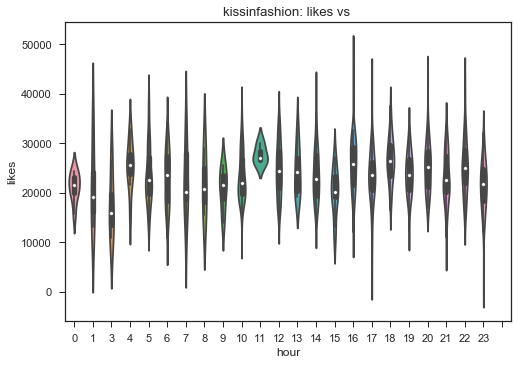

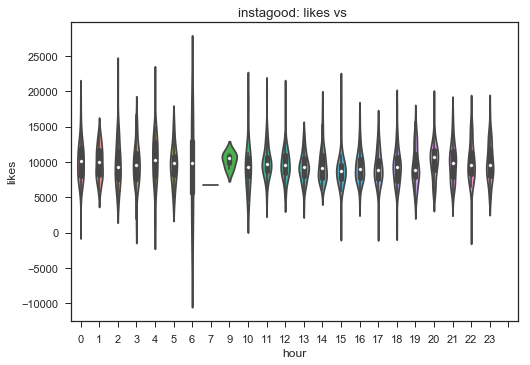

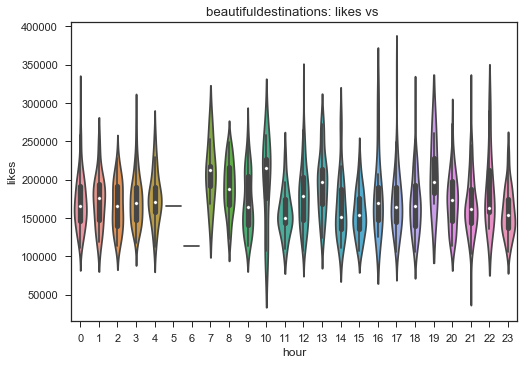

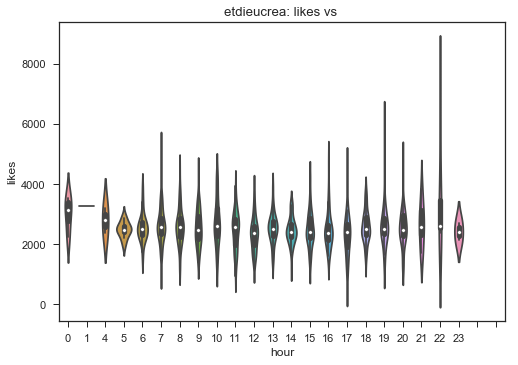

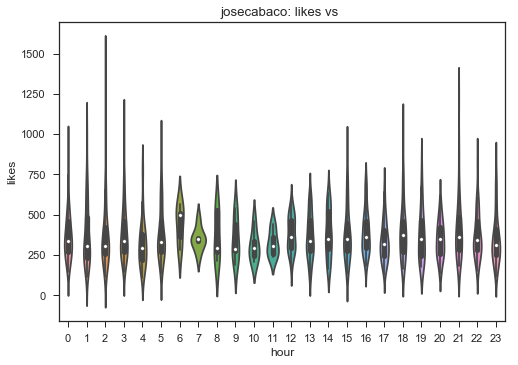

In [9]:
# Get plot of likes vs hour
for user in usernames:
    sns.violinplot(x=labels[user]['hour'], y=labels[user]['likes'])
    plt.xticks([x for x in range(24)])
    plt.xlim(-0.5, 23.5)
    plt.title("{}: likes vs ".format(user))
    sns.plt.show()

Let's plot the day distribution for the different users.

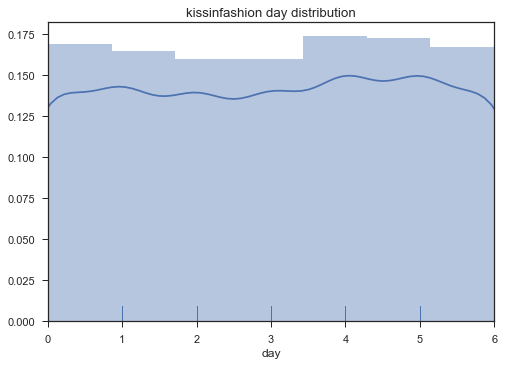

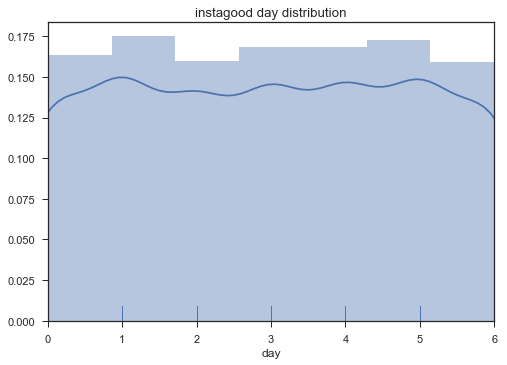

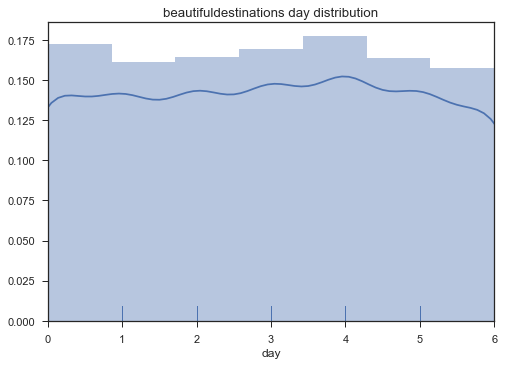

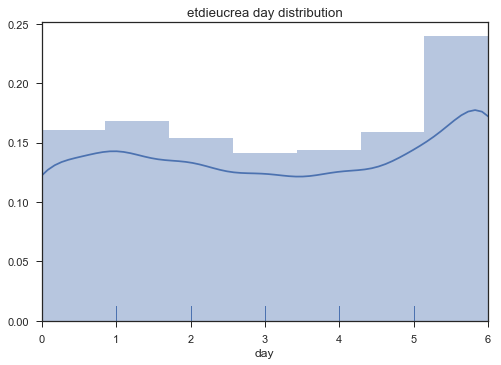

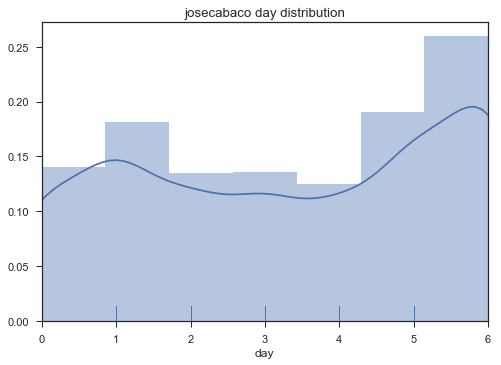

In [10]:
for user in usernames:
    sns.distplot(labels[user]['day'], rug=True, bins=7)
    plt.xticks([x for x in range(8)])
    plt.xlim(0, 6)
    plt.title("{} day distribution".format(user))
    sns.plt.show()

Get violin plot of likes vs day

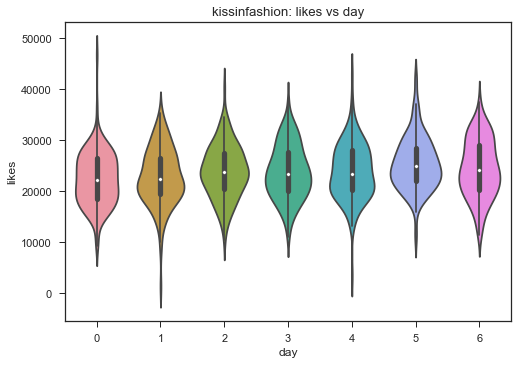

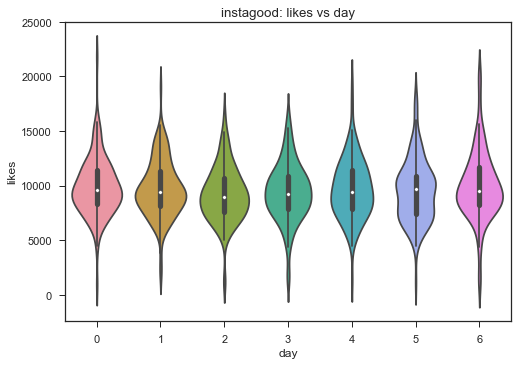

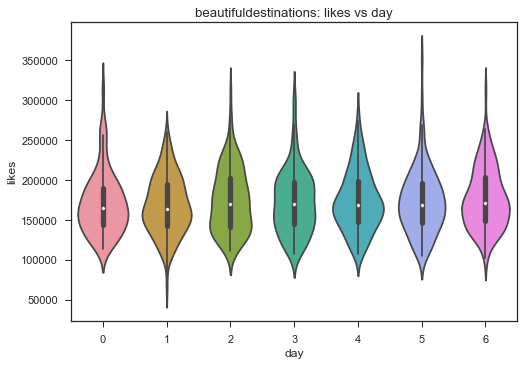

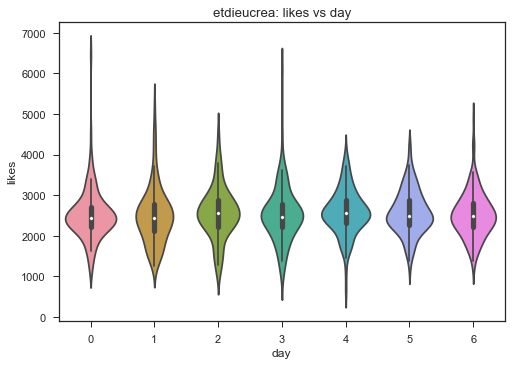

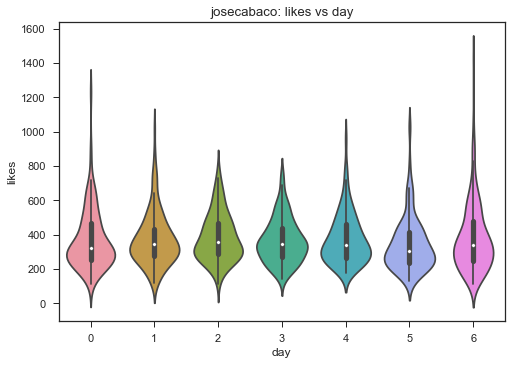

In [11]:
# Get plot of likes vs hour
for user in usernames:
    sns.violinplot(x=labels[user]['day'], y=labels[user]['likes'])
    plt.xticks([x for x in range(7)])
    plt.xlim(-0.5, 6.5)
    plt.title("{}: likes vs day".format(user))
    sns.plt.show()

## Data Munging
Now we will clean up the datasets: First, create binary variables for the hour (group by 6 hour inteverals) and day, then split the datasets into a label vector and a feature matrix.

In [12]:
# group per hour
for user in usernames:
    # Zero out labels
    labels[user]['hour_0005'] = np.where(labels[user]['hour'] <= 5, 1, 0)
    labels[user]['hour_0611'] = np.where(np.logical_and(labels[user]['hour'] >= 6, labels[user]['hour'] <= 11), 1, 0)
    labels[user]['hour_1217'] = np.where(np.logical_and(labels[user]['hour'] >= 12, labels[user]['hour'] <= 17), 1, 0)
    labels[user]['hour_1823'] = np.where(np.logical_and(labels[user]['hour'] >= 18, labels[user]['hour'] <= 23), 1, 0)
    train[user]['hour_0005'] = np.where(train[user]['hour'] <= 5, 1, 0)
    train[user]['hour_0611'] = np.where(np.logical_and(train[user]['hour'] >= 6, train[user]['hour'] <= 11), 1, 0)
    train[user]['hour_1217'] = np.where(np.logical_and(train[user]['hour'] >= 12, train[user]['hour'] <= 17), 1, 0)
    train[user]['hour_1823'] = np.where(np.logical_and(train[user]['hour'] >= 18, train[user]['hour'] <= 23), 1, 0)
    test[user]['hour_0005'] = np.where(test[user]['hour'] <= 5, 1, 0)
    test[user]['hour_0611'] = np.where(np.logical_and(test[user]['hour'] >= 6, test[user]['hour'] <= 11), 1, 0)
    test[user]['hour_1217'] = np.where(np.logical_and(test[user]['hour'] >= 12, test[user]['hour'] <= 17), 1, 0)
    test[user]['hour_1823'] = np.where(np.logical_and(test[user]['hour'] >= 18, test[user]['hour'] <= 23), 1, 0)
# group per day
for user in usernames:
    labels[user]['monday'] = np.where(labels[user]['day'] == 0, 1, 0)
    labels[user]['tuesday'] = np.where(labels[user]['day'] == 1, 1, 0)
    labels[user]['wednesday'] = np.where(labels[user]['day'] == 2, 1, 0)
    labels[user]['thursday'] = np.where(labels[user]['day'] == 3, 1, 0)
    labels[user]['friday'] = np.where(labels[user]['day'] == 4, 1, 0)
    labels[user]['saturday'] = np.where(labels[user]['day'] == 5, 1, 0)
    labels[user]['sunday'] = np.where(labels[user]['day'] == 6, 1, 0)
    train[user]['monday'] = np.where(train[user]['day'] == 0, 1, 0)
    train[user]['tuesday'] = np.where(train[user]['day'] == 1, 1, 0)
    train[user]['wednesday'] = np.where(train[user]['day'] == 2, 1, 0)
    train[user]['thursday'] = np.where(train[user]['day'] == 3, 1, 0)
    train[user]['friday'] = np.where(train[user]['day'] == 4, 1, 0)
    train[user]['saturday'] = np.where(train[user]['day'] == 5, 1, 0)
    train[user]['sunday'] = np.where(train[user]['day'] == 6, 1, 0)
    test[user]['monday'] = np.where(test[user]['day'] == 0, 1, 0)
    test[user]['tuesday'] = np.where(test[user]['day'] == 1, 1, 0)
    test[user]['wednesday'] = np.where(test[user]['day'] == 2, 1, 0)
    test[user]['thursday'] = np.where(test[user]['day'] == 3, 1, 0)
    test[user]['friday'] = np.where(test[user]['day'] == 4, 1, 0)
    test[user]['saturday'] = np.where(test[user]['day'] == 5, 1, 0)
    test[user]['sunday'] = np.where(test[user]['day'] == 6, 1, 0)
# test to see if this column is working
labels[usernames[0]]['hour_1823'].head()

0    1
1    1
2    1
3    0
4    0
Name: hour_1823, dtype: int32

The previous columns were added at the end of the dataframe. Let's move it to the beginning, where the time columns were located, and drop those columns as they are not needed anymore. 

In [13]:
# reorganlize labels
time = {}
for user in usernames:
    columns = labels[user].columns.values.tolist()
    columns = columns[0:5] + columns[-11:] + columns[5:-11]
    labels[user] = labels[user][columns]
    train[user] = train[user][columns]
    test[user] = test[user][columns]
    time[user] = labels[user].loc[:, ['hour', 'day']]
    labels[user] = labels[user].drop('hour', 1)
    labels[user] = labels[user].drop('day', 1)
    train[user] = train[user].drop('hour', 1)
    train[user] = train[user].drop('day', 1)
    test[user] = test[user].drop('hour', 1)
    test[user] = test[user].drop('day', 1)

In [14]:
# Look at the dataset again to see the binary time variables
labels[usernames[0]].iloc[:, 0:16].head()

,likes,username,display_src,hour_0005,hour_0611,hour_1217,hour_1823,monday,tuesday,wednesday,thursday,friday,saturday,sunday,toy,product
0,1351,kissinfashion,https://scontent-sjc2-1.cdninstagram.com/t51.2...,0,0,0,1,0,1,0,0,0,0,0,0.729818,0.724174
1,8831,kissinfashion,https://scontent-sjc2-1.cdninstagram.com/t51.2...,0,0,0,1,0,1,0,0,0,0,0,NaN,NaN
2,16879,kissinfashion,https://scontent-sjc2-1.cdninstagram.com/t51.2...,0,0,0,1,0,1,0,0,0,0,0,NaN,NaN
3,16305,kissinfashion,https://scontent-sjc2-1.cdninstagram.com/t51.2...,0,0,1,0,0,1,0,0,0,0,0,NaN,NaN
4,12959,kissinfashion,https://scontent-sjc2-1.cdninstagram.com/t51.2...,0,0,1,0,0,1,0,0,0,0,0,NaN,NaN


Next, split up the dataset into a like vector (the "y" in the ML model) and a feature matrix (the "X" in the ML model)

In [15]:
# Clean up dataset
# datasets to prepare for ML
y_label, X_label = {}, {}
y_train, X_train = {}, {}
y_test, X_test = {}, {}
# Iterate over all datasets. Likes is the Y data, take only labels for the X data, and replace NAs with 0
for user in usernames:
    # Label dataset
    y_label[user] = labels[user]['likes'].values
    X_label[user] = labels[user].ix[:, 3:]
    X_label[user].fillna(0, inplace=True)
    X_label[user] = X_label[user].values
    # Training dataset
    y_train[user] = train[user]['likes'].values
    X_train[user] = train[user].ix[:, 3:]
    X_train[user].fillna(0, inplace=True)
    X_train[user] = X_train[user].values
    # Test dataset
    y_test[user] = test[user]['likes'].values
    X_test[user] = test[user].ix[:, 3:]
    X_test[user].fillna(0, inplace=True)
    X_test[user] = X_test[user].values

Now let's use [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) to visualize the data in lower dimensions. This should visualize groupings of data.

kissinfashion: explained variance ratio (first two components): [ 0.08955687  0.07686898]


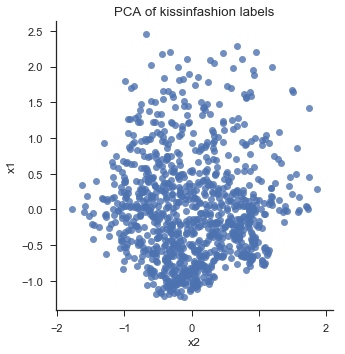

instagood: explained variance ratio (first two components): [ 0.1155563   0.07794532]


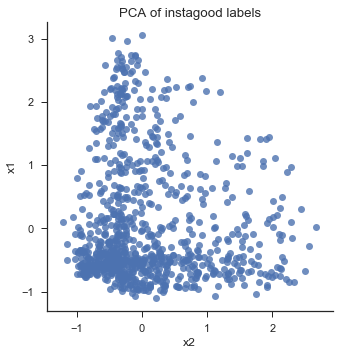

beautifuldestinations: explained variance ratio (first two components): [ 0.09369838  0.08969656]


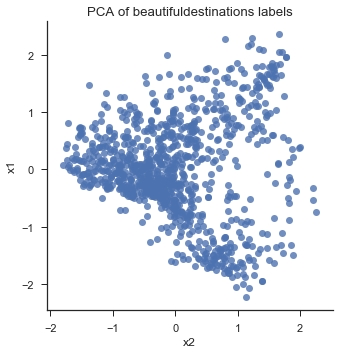

etdieucrea: explained variance ratio (first two components): [ 0.13055168  0.07125834]


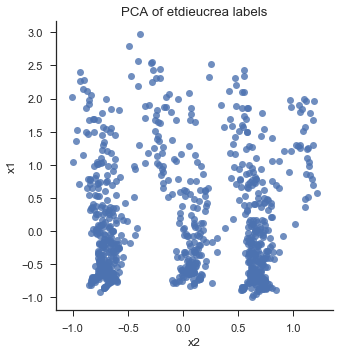

josecabaco: explained variance ratio (first two components): [ 0.07109533  0.06216781]


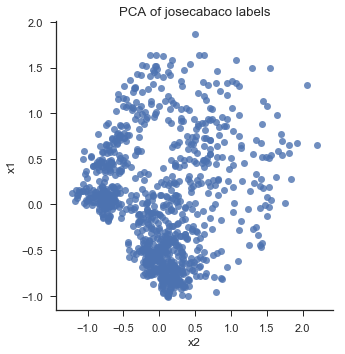

In [16]:
pca = {}
labels_r = {}
for user in usernames:
    pca[user] = PCA(n_components=2)
    labels_r[user] = pca[user].fit(X_label[user]).transform(X_label[user])
    labels_r[user] = pd.DataFrame(columns=['x1', 'x2'], data=labels_r[user])
    print '{}: explained variance ratio (first two components): {}'.format(user, pca[user].explained_variance_ratio_)
    sns.lmplot('x2', 'x1', data=labels_r[user], fit_reg=False)
    plt.title('PCA of {} labels'.format(user))
    sns.plt.show()

## Predictive Data Analysis

Here we apply a number of regression methods on the different users and store them so that we can select the right model. For hyperparameter selection we will use [Grid Search Cross Validation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to exhaustively search for the correct parameters.

We will apply a seperate model for each user, as the likes and features are different for each user. The models we will use are:
* Random (pick from a random normally distrubted variable of likes with parameters set by the training set; "worst-case" scenario)
* [Linear Regression](https://en.wikipedia.org/wiki/Linear_regression) (Ordinary Least Squares)
* Ridge Regression (OLS + a $L^2$ [regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization))
* Lasso Regression (OLS + a $L^1$ [regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization))
* Kernal Ridge Regression (Ridge Regression with the [kernel trick](https://en.wikipedia.org/wiki/Kernel_method))
* [Support Vector Machine](https://en.wikipedia.org/wiki/Support_vector_machine) Regression (Also with the [kernel trick](https://en.wikipedia.org/wiki/Kernel_method))
* [Random Forest](https://en.wikipedia.org/wiki/Random_forest) Regression (Bagging + random selection of features on a regression decision tree)

We will choose the best model based on the maximum number of "points" (absolute error within a specific threshold for each user), using the [mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) as a tie breaker as opposed to the [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) as the former is more closely related to the point scale.

In [17]:
reg = {} # Stores regression objects
y_pred = {} # Predicted number of Likes
mse = {} # Mean Squared Error
mae = {} # Mean Absolute Error
points = {} # Number of points earned by model
max_points = {} # Maximum points is getting the entire test set correct
select = {} # The selected model for the user
for user in usernames:
    # dictionary of models for each user
    reg[user] = {} # Container for regression models
    y_pred[user] = {} # Container for predictions
    mse[user] = {} # container for mean square error score
    mae[user] = {} # container for mean absolute error score
    points[user] = {} # container for instagram points score
    max_points[user] = len(y_test[user]) # Max points for user, entire test set correct
    select[user] = {} # container for model that was selected

In [18]:
# For kicks, let's create a model which just takes the number of likes randomly from the training distribution
model = 'random'
for user in usernames:
    mean = np.mean(y_train[user])
    std = np.std(y_train[user])
    y_pred[user][model] = np.clip(np.random.normal(loc=mean, scale=std, size=len(y_test[user])), 0, np.inf)
    mse[user][model] = mean_squared_error(y_test[user], y_pred[user][model])
    mae[user][model] = mean_absolute_error(y_test[user], y_pred[user][model])
    points[user][model] = get_points(y_test[user], y_pred[user][model], threshold=thresholds[user])
    print '{}: {} MAE ~ {}/{} points'.format(user, mae[user][model], points[user][model], max_points[user])

kissinfashion: 6819.58331326 MAE ~ 32/202 points
instagood: 2858.53288363 MAE ~ 64/202 points
beautifuldestinations: 43899.8980724 MAE ~ 50/202 points
etdieucrea: 637.137538146 MAE ~ 75/202 points
josecabaco: 178.198886806 MAE ~ 58/202 points


In [19]:
# Linear regression - no hyperparameters
model = 'linear'
for user in usernames:
    reg[user][model] = LinearRegression()
    reg[user][model].fit(X_train[user], y_train[user])
    y_pred[user][model] = reg[user][model].predict(X_test[user])
    mse[user][model] = mean_squared_error(y_test[user], y_pred[user][model])
    mae[user][model] = mean_absolute_error(y_test[user], y_pred[user][model])
    points[user][model] = get_points(y_test[user], y_pred[user][model], threshold=thresholds[user])
    print '{}: {} MAE ~ {}/{} points'.format(user, mae[user][model], points[user][model], max_points[user])

kissinfashion: 4552.61386139 MAE ~ 60/202 points
instagood: 2093.9009901 MAE ~ 86/202 points
beautifuldestinations: 33611.4059406 MAE ~ 81/202 points
etdieucrea: 456.534653465 MAE ~ 109/202 points
josecabaco: 132.866336634 MAE ~ 71/202 points


In [20]:
# Ridge regression - 1 hyperparameter (alpha)
model = 'ridge'
# Parameters to tune for CV
parameters = { 'alpha': [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75, 100, 500, 1000] }
for user in usernames:
    # Cross Validation and fitting
    reg[user][model] = GridSearchCV(Ridge(), parameters, cv=5, scoring='neg_mean_absolute_error')
    reg[user][model].fit(X_train[user], y_train[user])
    y_pred[user][model] = reg[user][model].predict(X_test[user])
    mse[user][model] = mean_squared_error(y_test[user], y_pred[user][model])
    mae[user][model] = mean_absolute_error(y_test[user], y_pred[user][model])
    points[user][model] = get_points(y_test[user], y_pred[user][model], threshold=thresholds[user])
    print '{}: {} MAE ~ {}/{} points'.format(user, mae[user][model], points[user][model], max_points[user])

kissinfashion: 4112.18383624 MAE ~ 67/202 points
instagood: 1845.4208167 MAE ~ 94/202 points
beautifuldestinations: 29729.7336933 MAE ~ 67/202 points
etdieucrea: 401.785995813 MAE ~ 118/202 points
josecabaco: 116.854176079 MAE ~ 78/202 points


In [21]:
# Lasso regression - 1 hyperparameter (alpha)
model = 'lasso'
# Parameters to tune for CV
parameters = { 'alpha': [0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75, 100, 500, 1000] }
for user in usernames:
    # Cross Validation and fitting
    reg[user][model] = GridSearchCV(Lasso(), parameters, cv=5, scoring='neg_mean_absolute_error')
    reg[user][model].fit(X_train[user], y_train[user])
    y_pred[user][model] = reg[user][model].predict(X_test[user])
    mse[user][model] = mean_squared_error(y_test[user], y_pred[user][model])
    mae[user][model] = mean_absolute_error(y_test[user], y_pred[user][model])
    points[user][model] = get_points(y_test[user], y_pred[user][model], threshold=thresholds[user])
    print '{}: {} MAE ~ {}/{} points'.format(user, mae[user][model], points[user][model], max_points[user])

C:\Anaconda3\envs\Python2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


kissinfashion: 4157.52850314 MAE ~ 63/202 points
instagood: 1841.33991476 MAE ~ 96/202 points
beautifuldestinations: 30389.8472594 MAE ~ 65/202 points
etdieucrea: 401.405645914 MAE ~ 122/202 points
josecabaco: 116.67074797 MAE ~ 78/202 points


In [22]:
# Kernel Ridge regression - 3 hyperparameters (kernel, gamma, alpha)
model = 'kernelridge'
# Parameters to tune for CV
parameters = { 'kernel': ['rbf'],
              'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
              'alpha': [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75, 100, 250, 500, 1000] }
for user in usernames:
    # Cross Validation and fitting
    reg[user][model] = GridSearchCV(KernelRidge(), parameters, cv=5, scoring='neg_mean_absolute_error')
    reg[user][model].fit(X_train[user], y_train[user])
    y_pred[user][model] = reg[user][model].predict(X_test[user])
    mse[user][model] = mean_squared_error(y_test[user], y_pred[user][model])
    mae[user][model] = mean_absolute_error(y_test[user], y_pred[user][model])
    points[user][model] = get_points(y_test[user], y_pred[user][model], threshold=thresholds[user])
    print '{}: {} MAE ~ {}/{} points'.format(user, mae[user][model], points[user][model], max_points[user])

kissinfashion: 4110.57801598 MAE ~ 67/202 points
instagood: 1852.42063023 MAE ~ 93/202 points
beautifuldestinations: 29683.0691751 MAE ~ 67/202 points
etdieucrea: 401.187860321 MAE ~ 122/202 points
josecabaco: 116.177530226 MAE ~ 79/202 points


In [23]:
# Support Vector Machine regression - 3 hyperparameters (kernel, gamma, C)
model = 'svr'
# Parameters to tune for CV
parameters = { 'kernel': ['rbf'],
              'gamma': ['auto', 1e-2, 1e-3, 1e-4, 1e-5],
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
for user in usernames:
    # Cross Validation and fitting
    reg[user][model] = GridSearchCV(SVR(), parameters, cv=5, scoring='neg_mean_absolute_error')
    reg[user][model].fit(X_train[user], y_train[user])
    y_pred[user][model] = reg[user][model].predict(X_test[user])
    mse[user][model] = mean_squared_error(y_test[user], y_pred[user][model])
    mae[user][model] = mean_absolute_error(y_test[user], y_pred[user][model])
    points[user][model] = get_points(y_test[user], y_pred[user][model], threshold=thresholds[user])
    print '{}: {} MAE ~ {}/{} points'.format(user, mae[user][model], points[user][model], max_points[user])

kissinfashion: 4129.06994594 MAE ~ 65/202 points
instagood: 1933.3969209 MAE ~ 104/202 points
beautifuldestinations: 30826.8349817 MAE ~ 73/202 points
etdieucrea: 402.441779542 MAE ~ 122/202 points
josecabaco: 113.484982268 MAE ~ 76/202 points


In [23]:
# Random Forest Regressor - 5 hyperparameters
model = 'randomforest'
# Parameters to tune for CV
parameters = { 'n_estimators': [120, 300, 500, 800],
             'max_depth': [5, 8, 15, 25, 30],
             'min_samples_split': [2, 5, 10, 15, 100],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_features': ['log2', 'sqrt', None]
            }
for user in usernames:
    # Cross Validation and fitting
    reg[user][model] = GridSearchCV(RandomForestRegressor(n_jobs=-1), parameters, cv=5, scoring='neg_mean_absolute_error')
    reg[user][model].fit(X_train[user], y_train[user])
    y_pred[user][model] = reg[user][model].predict(X_test[user])
    mse[user][model] = mean_squared_error(y_test[user], y_pred[user][model])
    mae[user][model] = mean_absolute_error(y_test[user], y_pred[user][model])
    points[user][model] = get_points(y_test[user], y_pred[user][model], threshold=thresholds[user])
    print '{}: {} MAE ~ {}/{} points'.format(user, mae[user][model], points[user][model], max_points[user])

kissinfashion: 4158.52716627 MAE ~ 66/202 points
instagood: 1842.60275412 MAE ~ 98/202 points
beautifuldestinations: 29246.2205219 MAE ~ 72/202 points
etdieucrea: 406.511312956 MAE ~ 120/202 points
josecabaco: 115.255640783 MAE ~ 72/202 points


Now we will select the model. The choices are:
* Minimized mean squared error
* Minimized mean absolute error
* Maximized Instagram points (absolute error based off of a per user threshold, with minimized mean absolute error as a tiebreaker)

We will choose the last option as we ultimately want to maximize points in this competition.

In [24]:
# Select model
choice = 'points'
chosen = {}
for user in usernames:
    if choice == 'mse':
        model = min(mse[user], key=mse[user].get)
    elif choice == 'points':
        # tie breaker on MAE
        highest = max(points[user].values())
        tie = [k for k, v in points.items() if v == highest]
        if len(tie) <= 1:
            model = max(points[user], key=points[user].get)
        else:
            selection = {k: mae[user][k] for k in tie}
            model = min(selection[user], key=selection[user].get)
    elif choice == 'mae':
        model = min(mae[user], key=mae[user].get)
    else:
        # Just use MAE
        model = min(mae[user], key=mse[user].get)
    select[user] = reg[user][model]
    chosen[user] = model
    print '{}: {} ~ {}'.format(user, model, select[user].best_params_ if hasattr(select[user], 'best_params_') else None)

kissinfashion: ridge ~ {'alpha': 50}
instagood: svr ~ {'kernel': 'rbf', 'C': 1000, 'gamma': 0.01}
beautifuldestinations: linear ~ None
etdieucrea: kernelridge ~ {'alpha': 3, 'gamma': 0.01, 'kernel': 'rbf'}
josecabaco: kernelridge ~ {'alpha': 75, 'gamma': 1e-05, 'kernel': 'rbf'}


#### Learning Curves
Although we don't have access to new data (technically we do but it's on a per post basis using the API which is orders of magnitude below the current amount of training data) I'd like to see how each model scales with training data to look at underfitting/overfitting of each chosen model. We plot a [learning curve](http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve) for each chosen model.

In [25]:
from sklearn.model_selection import learning_curve
from sklearn.dummy import DummyRegressor

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_absolute_error')
    train_scores, test_scores = -train_scores, -test_scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    return plt

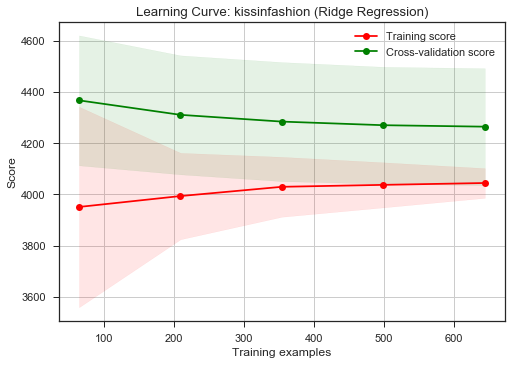

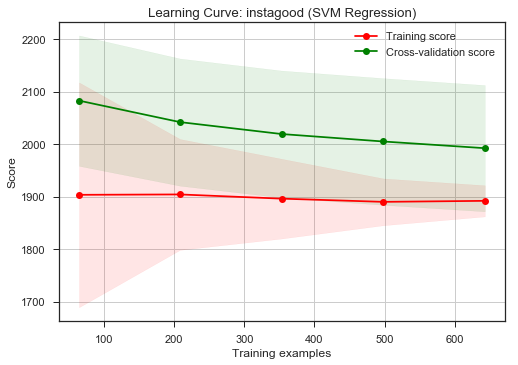

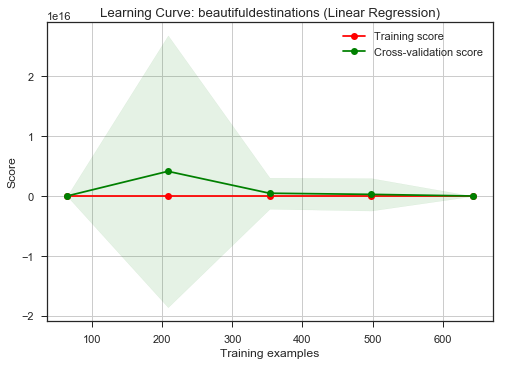

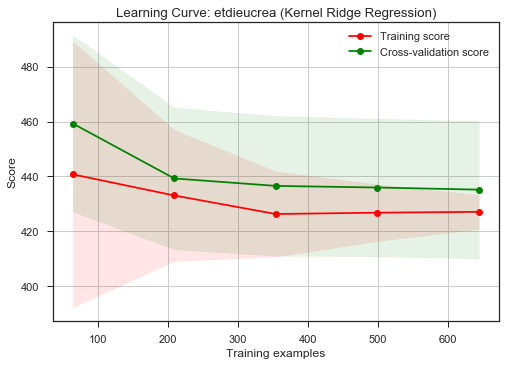

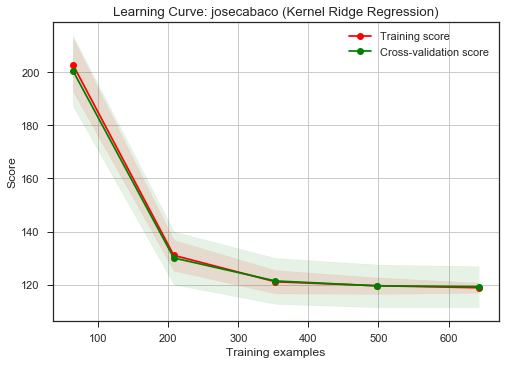

In [26]:
from sklearn.model_selection import ShuffleSplit
# Plot learning curve for each user for their chosen model
for user in usernames:
    if chosen[user] == 'linear':
        model = LinearRegression()
        title = "Learning Curve: {} (Linear Regression)".format(user)
    elif chosen[user] == 'ridge':
        model = Ridge(**(select[user].best_params_))
        title = "Learning Curve: {} (Ridge Regression)".format(user)
    elif chosen[user] == 'lasso':
        model = Lasso(**(select[user].best_params_))
        title = "Learning Curve: {} (Lasso Regression)".format(user)
    elif chosen[user] == 'kernelridge':
        model = KernelRidge(**(select[user].best_params_))
        title = "Learning Curve: {} (Kernel Ridge Regression)".format(user)
    elif chosen[user] == 'svr':
        model = SVR(**(select[user].best_params_))
        title = "Learning Curve: {} (SVM Regression)".format(user)
    elif chosen[user] == 'randomforest':
        model = RandomForestRegressor(n_jobs=-1, **(select[user].best_params_))
        title = "Learning Curve: {} (Random Forest Regression)".format(user)
    else:
        model = DummyRegressor(strategy="mean")
        title = "Learning Curve: {} (Dummy Regressor)".format(user)
    # Cross validation with 100 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
    plot_learning_curve(model, title, X_train[user], y_train[user], ylim=None, cv=cv, n_jobs=-1)

### Save models
Finally, we will save the models (by pickling them in a shelf) as well as the labels so we can use them for prediction for new data.

In [27]:
# Save models to a file
import shelve
filename = '../src/models/labels.pkl'
storage = shelve.open(filename)
for user in usernames:
    storage[user] = select[user]
storage.close()

In [28]:
# Get columns of the labels and store in a file
columns = {}
labelname = '../src/models/labelcolumns.pkl'
storage = shelve.open(labelname)
for user in usernames:
    columns[user] = labels[user].ix[:, 14:].columns.values.tolist()
    print '{}: {} ...'.format(user, columns[user][0:5])
    storage[user] = columns[user]
storage.close()

kissinfashion: [u'toy', u'product', u'interaction', u'textile', u'fur'] ...
instagood: [u'product', u'vacation', u'sea', u'clothing', u'photo_shoot'] ...
beautifuldestinations: [u'vacation', u'resort', u'caribbean', u'estate', u'lagoon'] ...
etdieucrea: [u'interaction', u'textile', u'fur', u'vacation', u'estate'] ...
josecabaco: [u'toy', u'product', u'textile', u'sea', u'clothing'] ...


In [29]:
# Testing the storage to see if it works and we get our models back
storage = shelve.open(filename)
for user in usernames:
    regression = storage[user]
    print user
    # print regression model
    print regression
    # print one prediction
    print regression.predict(X_test[user][0, :].reshape(1, -1))
    print
storage.close()

kissinfashion
GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)
[ 24619.70770075]

instagood
GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': ['auto', 0.01, 0.001, 0.0001, 1e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)
[ 8791.6420279]


In [30]:
for user in usernames:
    print X_train[user].shape

(805L, 143L)
(804L, 212L)
(804L, 200L)
(805L, 148L)
(804L, 192L)
